In [242]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

%config IPCompleter.greedy=True

In [9]:
polish_corpora_path = '../../../polish_corpora.txt'
poleval2_path = '../../../poleval_2grams.txt'
poleval3_path = '../../../poleval_3grams.txt'

In [10]:
polish_corpora = []
polish_corpora_no_space = []

In [11]:
with open(polish_corpora_path, encoding="utf8") as f:
    for line in tqdm(f, desc='Loading data...', position=0, leave=True):
        line = line.strip().lower()
        polish_corpora.append(bytearray(line, 'UTF-8'))
        polish_corpora_no_space.append(bytearray(line.replace(' ', ''), 'UTF-8'))

Loading data...: 23011601it [01:42, 224885.68it/s]


In [14]:
print(f'Total size: {(sum([sys.getsizeof(x) for x in polish_corpora]) + sys.getsizeof(polish_corpora)) / 1048576:.1f}MB')

Total size: 4315.0MB


## Create dictionary

In [42]:
dictionary = set()

In [43]:
for line in tqdm(polish_corpora, desc='Loading data...', position=0, leave=True):
    for word in line.split():
        dictionary.add(bytes(word))

Loading data...: 100%|█████████████████████████████████████████████████| 23011601/23011601 [03:23<00:00, 113021.79it/s]


In [44]:
print(f'All words in dictionary: {len(dictionary)}')

All words in dictionary: 3591114


## Max Match Algorithm

In [109]:
def maxmatch(sentence: bytearray, dictionary: set) -> list:
    """ Cut the biggest prefix of the sentence until there is something to cut. """
    result_sentence: list = []
 
    n: int = len(sentence)
    index: int = 0
    while index < n:
        current_word: bytearray = sentence[index: index + 1]

        for j in range(n - 1, index, -1):
            if bytes(sentence[index: j]) in dictionary:
                current_word = sentence[index: j]
                break
            
        result_sentence.append(current_word)
        index += len(current_word)
        
    return result_sentence

## DP tokenization

In [230]:
def valid_sequence(k: int, text: bytearray, dictionary: set) -> bool:
    # True if text[1...k] is a valid sequence of words
    # False otherwise
    if text[:k] in WORDS:
        return True

    for j in reversed(range(1, k)):
        if text[:j] in WORDS and text[j:k] in WORDS:
            return True

    return False


def dp_tokenization(sentence: bytearray, dictionary: set) -> list:
    n: int = len(sentence)
    valid_seq_arr = [False] * n
    word_beg_candidate = [[] for _ in range(n)]
    act_length = [[] for _ in range(n)]

    for k in range(1, n + 1):
        if bytes(sentence[: k]) in dictionary:
            valid_seq_arr[k - 1] = True
            word_beg_candidate[k - 1].append(0)
            act_length[k - 1].append(k ** 2)

        for j in range(k):
            if valid_seq_arr[j] and bytes(sentence[j + 1:k]) in dictionary:
                valid_seq_arr[k - 1] = True
                word_beg_candidate[k - 1].append(j)
                act_length[k - 1].append((k - j - 1) ** 2)

    # dp counting sentence with biggest sum of squares
    answer = [0 for _ in range(n)]
    beginning = [-1 for _ in range(n)]

    # dp
    for i in reversed(range(1, n)):
        for j in range(len(word_beg_candidate[i])):
            act_beg = word_beg_candidate[i][j]

            if act_length[i][j] + answer[i] >= answer[act_beg]:
                answer[act_beg] = act_length[i][j] + answer[i]
                beginning[act_beg] = i

    final_sentence = []
    final_sentence.append(sentence[:beginning[0] + 1])
    start: int = beginning[0]

    # going back in dp constructing sentence
    while start > 0:
        final_sentence.append(sentence[start + 1: beginning[start] + 1])
        start = beginning[start]

    # sometimes when first word is a single letter it ss joined with the second word
    if not bytes(final_sentence[0]) in dictionary:
        final_sentence = [final_sentence[0][0: 1]] + final_sentence
        final_sentence[1] = final_sentence[1][1:]

    return final_sentence

## Text Similarity Metrics

In [165]:
def words_intersection_metric(sentence1: list, sentence2: list) -> float:
    """ Take the number of intersecting words from both tokenizations. """
    set1 = set(map(lambda x: bytes(x), sentence1))
    set2 = set(map(lambda x: bytes(x), sentence2))
    intersection: set = set1.intersection(set2)
    return len(intersection) / (len(set1) + len(set2) - len(intersection))


def letters_intersection_metric(sentence1: list, sentence2: list) -> float:
    """ Take the number of letters of intersecting words from both tokenizations. """
    set1 = set(map(lambda x: bytes(x), sentence1))
    set2 = set(map(lambda x: bytes(x), sentence2))
    intersection: set = set1.intersection(set2)
    
    n_letters_intersection: int = sum([len(word) for word in intersection])
    n_letters_set1: int = sum([len(word) for word in set1])
    n_letters_set2: int = sum([len(word) for word in set2])
    return n_letters_intersection / (n_letters_set1 + n_letters_set2 - n_letters_intersection)


def correspondence_metric(sentence1: list, sentence2: list) -> float:
    """ Take the number of letter of words from both tokenizations one by one. """
    n: int = min(len(sentence1), len(sentence2))
    
    n_similar_letters: int = 0
    total_similar_letters: int = sum([len(word) for word in sentence2])
    for i in range(n):
        set1 = set(sentence1[i])
        set2 = set(sentence2[i])
        intersection: set = set1.intersection(set2)
        n_similar_letters += len(intersection)
        
    return n_similar_letters / total_similar_letters

## Max Match on polish corpora

* Result: 31% accuracy using words_intersection_metric
* Result: 35% accuracy using letters_intersection_metric
* Result: 40% accuracy using correspondence_metric

In [190]:
scores1: list = []
scores2: list = []
scores3: list = []

In [191]:
# draw N random indices
N = 100000
random_sentences = np.random.randint(0, len(polish_corpora), N)

In [192]:
for i in tqdm(random_sentences, desc='Max Match ...' , leave=True, position=0):
    maxmatch_sentence = maxmatch(sentence=polish_corpora_no_space[i], dictionary=dictionary)
    score1 = simple_metric(maxmatch_sentence, polish_corpora[i].split())
    score2 = letters_intersection_metric(maxmatch_sentence, polish_corpora[i].split())
    score3 = correspondence_metric(maxmatch_sentence, polish_corpora[i].split())
    scores1.append(score1)
    scores2.append(score2)
    scores3.append(score3)

Max Match ...: 100%|█████████████████████████████████████████████████████████| 100000/100000 [00:58<00:00, 1707.35it/s]


In [193]:
scores1 = np.array(scores1)
scores2 = np.array(scores2)
scores3 = np.array(scores3)

In [194]:
print(f'Words intersection   ==>  Min: {scores1.min():.3f} | Max: {scores1.max():.3f} | Mean: {scores1.mean():.3f}')
print(f'Letters intersection ==>  Min: {scores2.min():.3f} | Max: {scores2.max():.3f} | Mean: {scores2.mean():.3f}')
print(f'Correspondence       ==>  Min: {scores3.min():.3f} | Max: {scores3.max():.3f} | Mean: {scores3.mean():.3f}')

Words intersection   ==>  Min: 0.000 | Max: 1.000 | Mean: 0.306
Letters intersection ==>  Min: 0.000 | Max: 1.000 | Mean: 0.347
Correspondence       ==>  Min: 0.018 | Max: 1.000 | Mean: 0.396


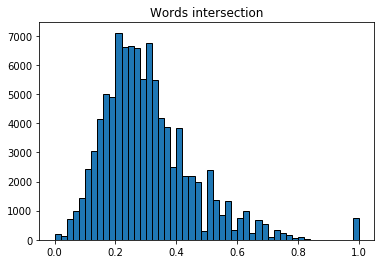

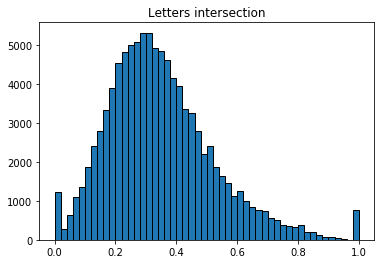

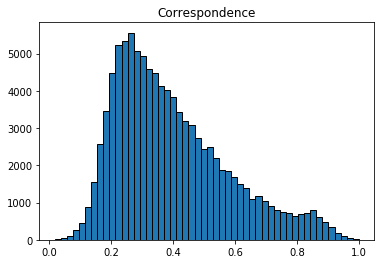

In [257]:
_ = plt.hist(scores1, bins=50, edgecolor='black')
plt.title('Words intersection')
plt.show()

_ = plt.hist(scores2, bins=50, edgecolor='black')
plt.title('Letters intersection')
plt.show()

_ = plt.hist(scores3, bins=50, edgecolor='black')
plt.title('Correspondence')
plt.show()

## DP tokenization on polish corpora
* Result: 50% accuracy using words_intersection_metric
* Result: 54% accuracy using letters_intersection_metric
* Result: 39% accuracy using correspondence_metric

In [260]:
dp_scores1: list = []
dp_scores2: list = []
dp_scores3: list = []

In [261]:
# draw N random indices
N = 100000
random_sentences = np.random.randint(0, len(polish_corpora), N)

In [262]:
for i in tqdm(random_sentences[17:] , desc='Max Match ...' , leave=True, position=0):
    maxmatch_sentence = dp_tokenization(sentence=polish_corpora_no_space[i], dictionary=dictionary)
    score1 = simple_metric(maxmatch_sentence, polish_corpora[i].split())
    score2 = letters_intersection_metric(maxmatch_sentence, polish_corpora[i].split())
    score3 = correspondence_metric(maxmatch_sentence, polish_corpora[i].split())
    dp_scores1.append(score1)
    dp_scores2.append(score2)
    dp_scores3.append(score3)

Max Match ...: 100%|████████████████████████████████████████████████████████████| 99983/99983 [07:12<00:00, 231.42it/s]


In [263]:
dp_scores1 = np.array(dp_scores1)
dp_scores2 = np.array(dp_scores2)
dp_scores3 = np.array(dp_scores3)

In [264]:
print(f'Words intersection   ==>  Min: {dp_scores1.min():.3f} | Max: {dp_scores1.max():.3f} | Mean: {dp_scores1.mean():.3f}')
print(f'Letters intersection ==>  Min: {dp_scores2.min():.3f} | Max: {dp_scores2.max():.3f} | Mean: {dp_scores2.mean():.3f}')
print(f'Correspondence       ==>  Min: {dp_scores3.min():.3f} | Max: {dp_scores3.max():.3f} | Mean: {dp_scores3.mean():.3f}')

Words intersection   ==>  Min: 0.000 | Max: 0.988 | Mean: 0.495
Letters intersection ==>  Min: 0.000 | Max: 1.000 | Mean: 0.535
Correspondence       ==>  Min: 0.014 | Max: 1.000 | Mean: 0.394


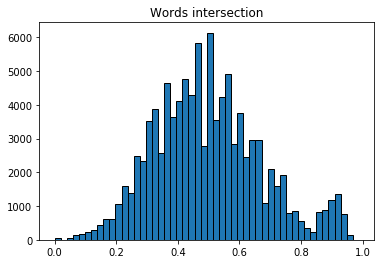

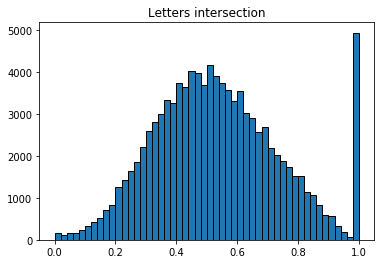

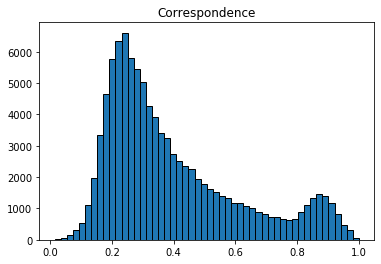

In [265]:
_ = plt.hist(dp_scores1, bins=50, edgecolor='black')
plt.title('Words intersection')
plt.show()

_ = plt.hist(dp_scores2, bins=50, edgecolor='black')
plt.title('Letters intersection')
plt.show()

_ = plt.hist(dp_scores3, bins=50, edgecolor='black')
plt.title('Correspondence')
plt.show()